#Sentiment Analysis

In [2]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
import nltk
nltk.download("vader_lexicon")
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
from IPython.display import display, HTML

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tjiay\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tjiay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tjiay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tjiay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tjiay\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [1]:
import torch
print("GPU available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


GPU available: True
GPU device: NVIDIA GeForce MX450


In [2]:
#Import data
# from google.colab import drive
# drive.mount('/content/drive')

# #Define file path and read the file
# file_path = "/content/drive/My Drive/DisneylandReviews.csv"
# df = pd.read_csv(file_path, encoding='ISO-8859-1')
# df.head()

df = pd.read_csv('DisneylandReviews.csv', encoding='ISO-8859-1')
display(HTML(df.to_html(max_rows=10, max_cols=10)))

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides its a Small World is absolutely fabulous and worth doing. The day we visited was fairly hot and relatively busy but the queues moved fairly well.,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironman .. Great feature n so Exciting, especially d whole scenery of HK (HK central area to Kowloon)!Antman .. Changed by previous Buzz lightyear! More or less d same, but I'm expecting to have something most!!However, my boys like it!!Space Mountain .. Turns into Star Wars!! This 1 is Great!!!For cast members (staffs) .. Felt bit MINUS point from before!!! Just dun feel like its a Disney brand!! Seems more local like Ocean Park or even worst!!They got no SMILING face, but just wanna u to enter n attraction n leave!!Hello this is supposed to be Happiest Place on Earth brand!! But, just really Dont feel it!!Bakery in Main Street now have more attractive delicacies n Disney theme sweets .. These are Good Points!!Last, they also have Starbucks now inside the theme park!!",Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,"Thanks God it wasn t too hot or too humid when I was visiting the park otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunately I didn t last until evening parade, but 8.5 hours was too much for me.There is plenty to do and everyone will find something interesting for themselves to enjoy.It wasn t extremely busy and the longest time I had to queue for certain attractions was 45 minutes (which is really not that bad).Although I had an amazing time, I felt a bit underwhelmed with choice of rides and attractions. The park itself is quite small (I was really expecting something grand even the main castle which was closed by the way was quite small).The food options are good, few coffee shops (including Starbucks) and plenty of gift shops. There was no issue with toilets as they are everywhere.All together it was a great day out and I really enjoyed it.",Disneyland_HongKong
3,670607911,4,2019-4,Australia,"HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work going on at present so a number of areas are closed off (including the famous castle) If you go midweek, it is not too crowded and certainly no where near as bus as LA Disneyland. We did notice on this visit that prices for food, drinks etc have really gone through the roof so be prepared to pay top dollar for snacks (and avoid the souvenir shops if you can) Regardless, kids will love it.",Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much, everything is fine. but its really crowded and hot in Hong Kong",Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thought it was brilliant. i visited all the hotels and stayed in the newport bay and also the kyriad hotels. the newport is a really nice hotel within walking distance of the parks. very big hotel. the kyriad is further away but still a really nice hotel..i saw all rooms at all hotels and they are all pretty much the same. thought the parks were brill and as it was july didn't really have to queue that much i thought. the food was the most expensive thing there. i did the character breakfast which is a must especially if you have young kids and also did buffalo bills which is a really good night. stayed up til late in the nightclub which i didn't think was expe

##Run sentiment analysis using VADER on the first 1000 reviews

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Create the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Apply pipeline (with progress bar for large datasets)
tqdm.pandas()  # Enables progress_apply
df_transformer = df[["Review_Text"]].dropna().copy()
df_transformer["bert_sentiment"] = df_transformer["Review_Text"].progress_apply(
    lambda x: sentiment_pipeline(x, truncation=True)[0]["label"]
)

# Preview results
display(HTML(df_transformer.to_html(max_rows=10, max_cols=10)))


Device set to use cpu
100%|██████████| 42656/42656 [3:29:56<00:00,  3.39it/s]   


,Review_Text,bert_sentiment
0,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides its a Small World is absolutely fabulous and worth doing. The day we visited was fairly hot and relatively busy but the queues moved fairly well.,5 stars
1,"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironman .. Great feature n so Exciting, especially d whole scenery of HK (HK central area to Kowloon)!Antman .. Changed by previous Buzz lightyear! More or less d same, but I'm expecting to have something most!!However, my boys like it!!Space Mountain .. Turns into Star Wars!! This 1 is Great!!!For cast members (staffs) .. Felt bit MINUS point from before!!! Just dun feel like its a Disney brand!! Seems more local like Ocean Park or even worst!!They got no SMILING face, but just wanna u to enter n attraction n leave!!Hello this is supposed to be Happiest Place on Earth brand!! But, just really Dont feel it!!Bakery in Main Street now have more attractive delicacies n Disney theme sweets .. These are Good Points!!Last, they also have Starbucks now inside the theme park!!",4 stars
2,"Thanks God it wasn t too hot or too humid when I was visiting the park otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunately I didn t last until evening parade, but 8.5 hours was too much for me.There is plenty to do and everyone will find something interesting for themselves to enjoy.It wasn t extremely busy and the longest time I had to queue for certain attractions was 45 minutes (which is really not that bad).Although I had an amazing time, I felt a bit underwhelmed with choice of rides and attractions. The park itself is quite small (I was really expecting something grand even the main castle which was closed by the way was quite small).The food options are good, few coffee shops (including Starbucks) and plenty of gift shops. There was no issue with toilets as they are everywhere.All together it was a great day out and I really enjoyed it.",4 stars
3,"HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work going on at present so a number of areas are closed off (including the famous castle) If you go midweek, it is not too crowded and certainly no where near as bus as LA Disneyland. We did notice on this visit that prices for food, drinks etc have really gone through the roof so be prepared to pay top dollar for snacks (and avoid the souvenir shops if you can) Regardless, kids will love it.",3 stars
4,"the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much, everything is fine. but its really crowded and hot in Hong Kong",3 stars
...,...,...
42651,i went to disneyland paris in july 03 and thought it was brilliant. i visited all the hotels and stayed in the newport bay and also the kyriad hotels. the newport is a really nice hotel within walking distance of the parks. very big hotel. the kyriad is further away but still a really nice hotel..i saw all rooms at all hotels and they are all pretty much the same. thought the parks were brill and as it was july didn't really have to queue that much i thought. the food was the most expensive thing there. i did the character breakfast which is a must especially if you have young kids and also did buffalo bills which is a really good night. stayed up til late in the nightclub which i didn't think was expensive at all and it was free entry as we were staying in the disney hotel.. altogether a really good 4 nts that we were there even better that it was all free!!!!!! can't wait to go back,4 stars
42652,"2 adults and 1 child of 11 visited Disneyland Paris beginning of Feb 04 and had an absolute fantastic time.W

In [12]:
df_transformer.to_csv('Labelled_DisneylandReviews.csv', index=False)

##Train classifier on the above data

In [3]:
df_transformer = pd.read_csv("Labelled_DisneylandReviews.csv")

In [3]:
# Count label frequency
label_counts = df_transformer["bert_sentiment"].value_counts().sort_index()

# Calculate percentages
label_percentages = (label_counts / label_counts.sum()) * 100

# Combine into a DataFrame
bert_sentiment_distribution = pd.DataFrame({
    "Count": label_counts,
    "Percentage": label_percentages.round(2)
})

# Display nicely
print(bert_sentiment_distribution)


                Count  Percentage
bert_sentiment                   
1 star           2386        5.59
2 stars          5093       11.94
3 stars          4767       11.18
4 stars         14428       33.82
5 stars         15982       37.47


##Bert Based Uncased

In [4]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Step 1: Create binary label column
df_transformer["risk_label"] = df_transformer["bert_sentiment"].apply(
    lambda x: 1 if x in ["1 star", "2 stars"] else 0
)

# Step 2: Train/test/val split
train_df, temp_df = train_test_split(
    df_transformer, test_size=0.3, stratify=df_transformer["risk_label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["risk_label"], random_state=42
)

# Rename columns for Hugging Face
train_ds = Dataset.from_pandas(train_df[["Review_Text", "risk_label"]].rename(
    columns={"Review_Text": "text", "risk_label": "label"}).reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df[["Review_Text", "risk_label"]].rename(
    columns={"Review_Text": "text", "risk_label": "label"}).reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df[["Review_Text", "risk_label"]].rename(
    columns={"Review_Text": "text", "risk_label": "label"}).reset_index(drop=True))

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)


c:\Users\tjiay\DSA3101_Group8_Project1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 6399/6399 [00:01<00:00, 3499.75 examples/s]


In [5]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./bert-high-risk",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    load_best_model_at_end=True,
    weight_decay=0.01,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train!
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tjiay\DSA3101_Group8_Project1\.venv\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\tjiay\AppData\Local\Temp\ipykernel_19108\4060393586.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.200900,0.261963,0.931229,0.780876
2,0.127400,0.234257,0.940919,0.821023
3,0.067300,0.306524,0.941388,0.826469


TrainOutput(global_step=11199, training_loss=0.13954748972386843, metrics={'train_runtime': 19759.3939, 'train_samples_per_second': 4.533, 'train_steps_per_second': 0.567, 'total_flos': 5933016084704256.0, 'train_loss': 0.13954748972386843, 'epoch': 3.0})

In [7]:
trainer.save_model("./saved_distilbert_highrisk_model")
tokenizer.save_pretrained("./saved_distilbert_highrisk_model")

('./saved_distilbert_highrisk_model\\tokenizer_config.json',
 './saved_distilbert_highrisk_model\\special_tokens_map.json',
 './saved_distilbert_highrisk_model\\vocab.txt',
 './saved_distilbert_highrisk_model\\added_tokens.json',
 './saved_distilbert_highrisk_model\\tokenizer.json')

In [6]:
trainer.evaluate(test_ds)

from sklearn.metrics import classification_report

# Get predictions
preds_output = trainer.predict(test_ds)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

# Print detailed report
print(classification_report(y_true, y_pred, target_names=["Not High Risk", "High Risk"]))



               precision    recall  f1-score   support

Not High Risk       0.95      0.98      0.96      5277
    High Risk       0.88      0.75      0.81      1122

     accuracy                           0.94      6399
    macro avg       0.91      0.86      0.89      6399
 weighted avg       0.94      0.94      0.94      6399



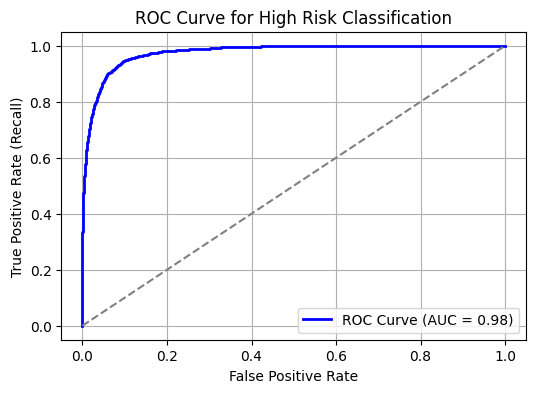

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities for class 1
y_true = preds_output.label_ids
y_score = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=1).numpy()[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for High Risk Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
